# Feature based approach


In [1]:
#import libraries needed
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
# %matplotlib inline

### Data exploration

In [2]:
#training data for feature based approach
raw = pd.read_csv("/kaggle/input/csm6420-a2/train_feat.csv")
zeros = raw.isnull().sum().sum()
print(f"Total missing values: {zeros}")
data = raw.fillna(value=0)

Total missing values: 8


In [3]:
print(f"Training Data: {data.info()}")
# print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13062 entries, 0 to 13061
Columns: 190 entries, ID to F187
dtypes: float64(188), object(2)
memory usage: 18.9+ MB
Training Data: None


In [4]:
X = data.iloc[:,2:]
y = data['Type']

In [5]:
# different labels
diff_types = set(y)
print(diff_types)

{'O', 'N', '~', 'A'}


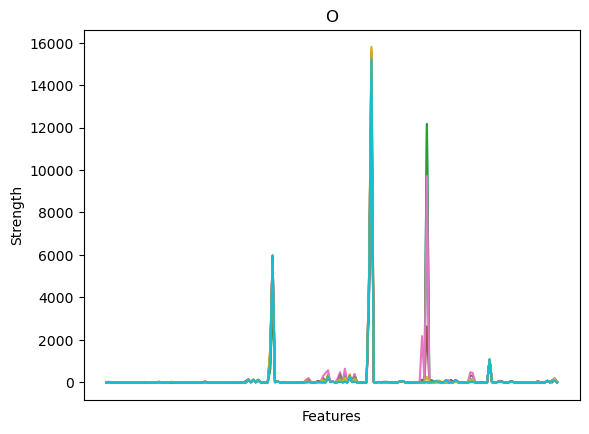

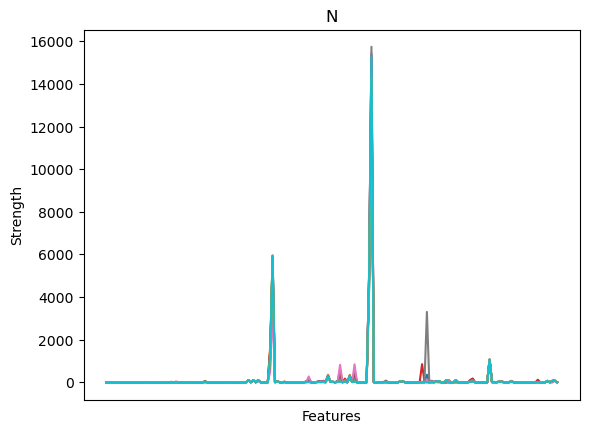

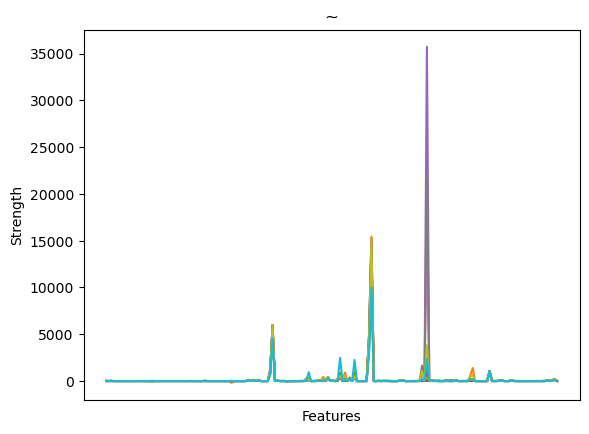

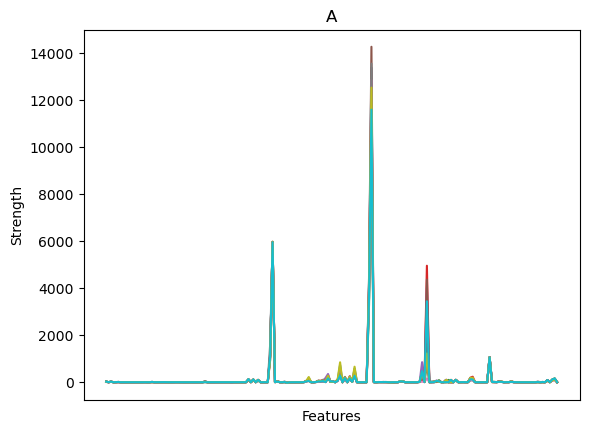

In [6]:
import random
for tpe in diff_types:
    plt.clf()
    for i in range(10):
        index = random.randint(1, 100)
        first_instance = data.loc[data.Type == tpe].iloc[index]
        feats = first_instance.drop(['Type', 'ID'])
        feats.plot()
    plt.xticks([])
    plt.xlabel("Features")
    plt.ylabel("Strength")
    plt.title(tpe)
    plt.show()

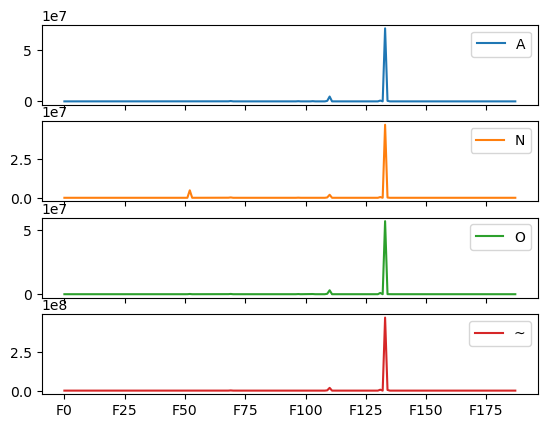

In [7]:
variation =  data.groupby('Type').var()
# plt.bar(variation.columns, variation.max()
# variation.max().max()
ax = variation.T.plot.line(subplots=True)

# PreProcess data

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6420, stratify = y)

In [9]:
# x and y train data
from sklearn import preprocessing

#extract features and labels

#encode labels to 0, 1, 2, 3
label_encoder = preprocessing.LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
print(np.unique(y_train_encoded))
print(label_encoder.inverse_transform(np.unique(y_train_encoded)))

[0 1 2 3]
['A' 'N' 'O' '~']


# Encoded values:

- 0 = A
- 1 = N
- 2 = O
- 3 = ~

N    7721
O    3857
A    1160
~     324
Name: Type, dtype: int64
N    0.591104
O    0.295284
A    0.088807
~    0.024805
Name: Type, dtype: float64


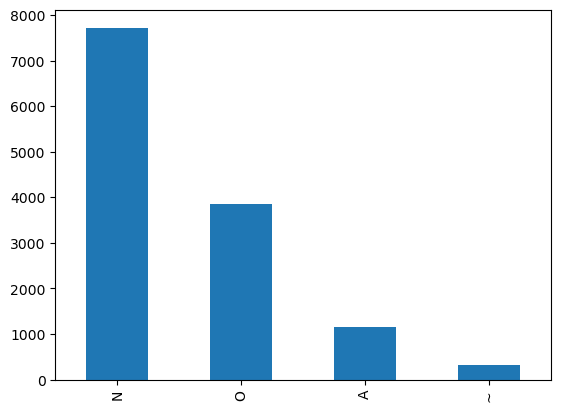

In [10]:
#visualise distribution of class labels
data.Type.value_counts().plot(kind='bar')
print(data.Type.value_counts())
print(data.Type.value_counts()/13062)

## resample data to balance out the labels

N length:  5404
O length:  2700
A length:  812
Noisy length:  227
~~~~~~~~~~~~~~~~~~~~
N balanced length:  2972
O balanced length:  2972
A balanced length:  2972
Noisy length:  227
1    2972
2    2972
0    2972
3     227
Name: label, dtype: int64


<AxesSubplot:>

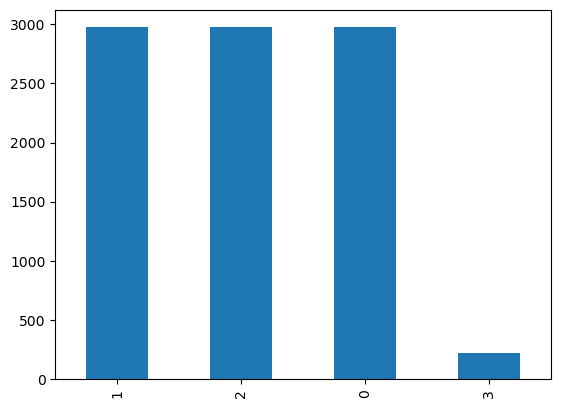

In [11]:
#resample data to balance labels
from sklearn.utils import resample
x_train['label'] = y_train_encoded
unbalanced = x_train

Ns = unbalanced[unbalanced.label == 1]
Os = unbalanced[unbalanced.label == 2]
As = unbalanced[unbalanced.label == 0]
noisy = unbalanced[unbalanced.label == 3]

print("N length: ", len(Ns))
print("O length: ", len(Os))
print("A length: ", len(As))
print("Noisy length: ", len(noisy))

avg = np.mean((len(Ns),len(Os) ,len(As)))

balanced_N = resample(Ns, n_samples = int(avg), replace=False)
balanced_O = resample(Os, n_samples = int(avg), replace=True)
balanced_A = resample(As, n_samples = int(avg), replace=True)
balanced_noise = resample(noisy, n_samples = int(avg), replace=True)
print("~~~~~~~~~~~~~~~~~~~~")
print("N balanced length: ", len(balanced_N))
print("O balanced length: ", len(balanced_O))
print("A balanced length: ", len(balanced_A))
print("Noisy length: ", len(noisy))

balanceddf = pd.concat([balanced_N, balanced_O,balanced_A, noisy])
print(balanceddf.label.value_counts())

balanceddf.label.value_counts().plot(kind='bar')

In [12]:
print(balanceddf.head(1))

        F0    F1   F2   F3   F4   F5        F6        F7        F8        F9  \
2016 -19.0  19.0  0.0  0.0  0.0  0.0  0.021739  0.019862  0.024697  0.008746   

      ...      F179      F180  F181  F182       F183  F184       F185  \
2016  ...  4.774658 -0.054591  16.0   0.0  87.209302   0.0  90.225564   

           F186   F187  label  
2016  94.936709  0.712      1  

[1 rows x 189 columns]


# Test and train data:

In [13]:
x_train_balanced = balanceddf.drop(columns=['label'])
y_train_balanced = balanceddf.label
print(x_train_balanced.shape)
print(y_train_balanced.shape)
print(y_train_balanced.value_counts())

(9143, 188)
(9143,)
1    2972
2    2972
0    2972
3     227
Name: label, dtype: int64


In [14]:
print(x_test.shape)
print(y_test.shape)
print(y_test.value_counts())

(3919, 188)
(3919,)
N    2317
O    1157
A     348
~      97
Name: Type, dtype: int64


In [15]:
print(x_train_balanced.columns)

Index(['F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9',
       ...
       'F178', 'F179', 'F180', 'F181', 'F182', 'F183', 'F184', 'F185', 'F186',
       'F187'],
      dtype='object', length=188)


# Normlise data with standard scaler

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


x_train_normalised = pd.DataFrame(scaler.fit_transform(x_train_balanced), columns = x_train_balanced.columns)

x_test_normalised = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

# PCA dimenionality reduction

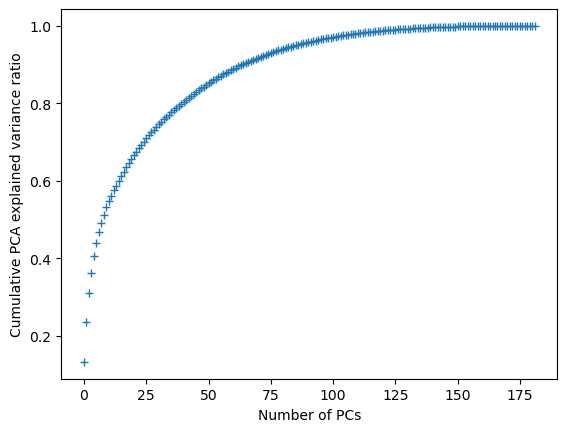

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components='mle')
pca.fit(x_train_normalised)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(var_cumsum, '+', linewidth=2)
plt.plot()
plt.ylabel('Cumulative PCA explained variance ratio')
plt.xlabel('Number of PCs')

plt.show()

In [18]:
print(var_cumsum[[50, 100, 125, 140]])
print(f'PCs to exlpain 50% of variance: {np.where(var_cumsum>0.50)[0][0]}')
print(f'PCs to exlpain 90% of variance: {np.where(var_cumsum>0.90)[0][0]}')
print(f'PCs to exlpain 95% of variance: {np.where(var_cumsum>0.95)[0][0]}')
print(f'PCs to exlpain 99% of variance: {np.where(var_cumsum>0.99)[0][0]}')

[0.85164646 0.97109616 0.99048734 0.99633248]
PCs to exlpain 50% of variance: 8
PCs to exlpain 90% of variance: 64
PCs to exlpain 95% of variance: 85
PCs to exlpain 99% of variance: 125


# normalise data with minmax scaler

- fit pca the same as above

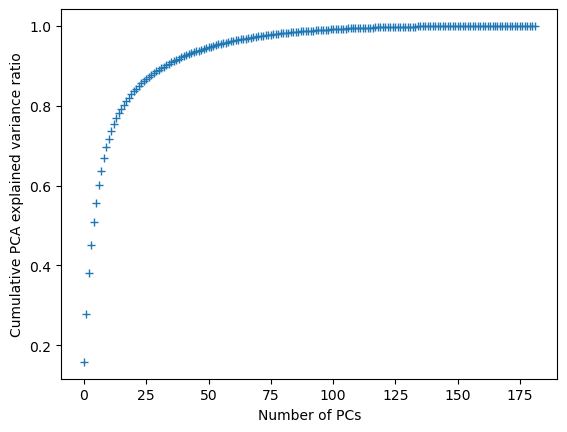

[0.94643131 0.99166579 0.99747519 0.99909165]
PCs to exlpain 50% of variance: 4
PCs to exlpain 90% of variance: 33
PCs to exlpain 95% of variance: 52
PCs to exlpain 99% of variance: 96


In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()


x_train_normalised = pd.DataFrame(scaler.fit_transform(x_train_balanced), columns = x_train_balanced.columns)

x_test_normalised = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)

pca = PCA(n_components='mle')
pca.fit(x_train_normalised)

var_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(var_cumsum, '+', linewidth=2)
plt.plot()
plt.ylabel('Cumulative PCA explained variance ratio')
plt.xlabel('Number of PCs')

plt.show()
print(var_cumsum[[50, 100, 125, 140]])
print(f'PCs to exlpain 50% of variance: {np.where(var_cumsum>0.50)[0][0]}')
print(f'PCs to exlpain 90% of variance: {np.where(var_cumsum>0.90)[0][0]}')
print(f'PCs to exlpain 95% of variance: {np.where(var_cumsum>0.95)[0][0]}')
print(f'PCs to exlpain 99% of variance: {np.where(var_cumsum>0.99)[0][0]}')

# Modelling Experiments

fit un processed data to models

In [20]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

random_seed = 6420
cross_val = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=random_seed)

hist = {}

In [21]:
print(x_train.columns)
print(x_test.columns)

Index(['F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9',
       ...
       'F179', 'F180', 'F181', 'F182', 'F183', 'F184', 'F185', 'F186', 'F187',
       'label'],
      dtype='object', length=189)
Index(['F0', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9',
       ...
       'F178', 'F179', 'F180', 'F181', 'F182', 'F183', 'F184', 'F185', 'F186',
       'F187'],
      dtype='object', length=188)


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def report(clf, name=None):
    clf.fit(x_train_balanced, y_train_balanced)
    pred = clf.predict(x_test)
    y_test_encoded = label_encoder.transform(y_test)
    out = label_encoder.inverse_transform(pred)
    report = classification_report(y_test, out, output_dict=True)
    f1 = report['weighted avg']['f1-score']
#     print('confusion matrix:\n',confusion_matrix(y_test, out))
#     print('\n\nclassification report:\n',report)
    print(f'\n\n=={clf}==\nweighted average f1 score = {f1:.4f}')
    matrix = ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test_encoded) 
    matrix.ax_.set_title(f"{name}\nF1 Score - {f1:.3f}")
    plt.show()
    return f1

### Random Forest

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 Best score: 0.913777775782463
 Best parameters: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 500}


==RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       n_estimators=500)==
weighted average f1 score = 0.8214


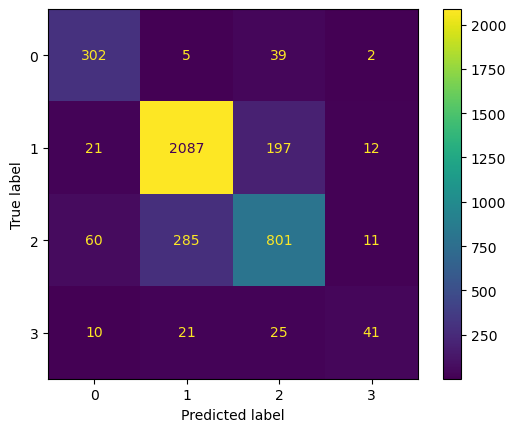

0.8213567024390618

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

tree_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [50, 75, 100],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
}

grid = GridSearchCV(RandomForestClassifier(),
                         tree_params, cv=cross_val, scoring='f1_weighted',
                         verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['random_forest'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")
report(grid.best_estimator_)

# Naive Bayes
Use gaussian naive bayes as data is not binomial

 Best score: 0.6803172955568921
 Best parameters: {'var_smoothing': 2.310129700083158e-09}


==GaussianNB(var_smoothing=2.310129700083158e-09)==
weighted average f1 score = 0.6925


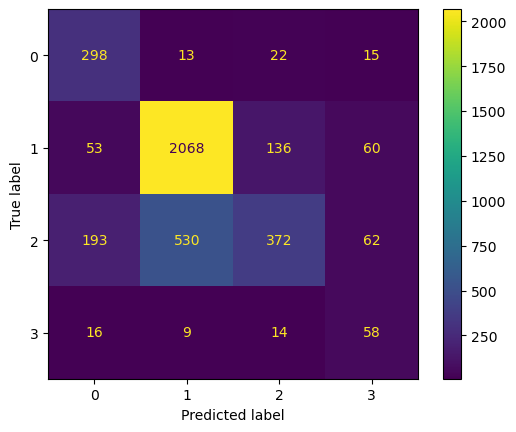

0.6925483865509178

In [26]:
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB()
bayes_grid = [{'var_smoothing': np.logspace(0,-9, 100)}]
grid = GridSearchCV(bayes,bayes_grid, cv=cross_val, scoring='f1_weighted',
                     verbose=0, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['Bayes'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")
report(grid.best_estimator_)

# KNN

Fitting 5 folds for each of 60 candidates, totalling 300 fits
 Best score: 0.823261543589252
 Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 26, 'weights': 'distance'}


==KNeighborsClassifier(algorithm='ball_tree', n_neighbors=26, weights='distance')==
weighted average f1 score = 0.6533


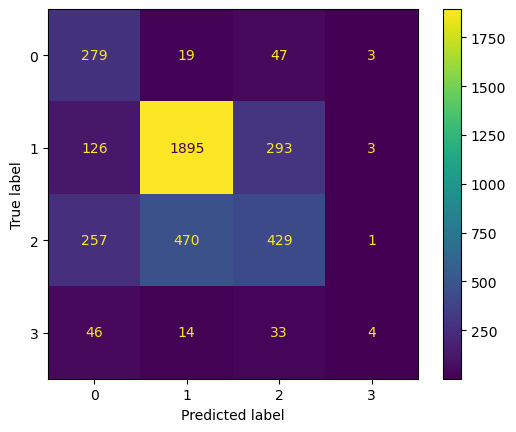

0.6532937306381982

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

knn = KNeighborsClassifier()

knn_grid = {'n_neighbors': range(1, 50, 5),
           'weights': ['uniform', 'distance'],
           'algorithm': ['ball_tree', 'kd_tree', 'brute']
           }

grid = GridSearchCV(knn,knn_grid, cv=cross_val, scoring='f1_weighted',
                     verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)
hist['knn'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")
report(grid.best_estimator_)

# Dimensionality Reduction and data scaling experiments

- Creating piplines for data standardising and dimensionality reduction

# Random forests 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
 Best score: 0.895029614009483
 Best parameters: {'reduce_dim__n_components': 85, 'scale': StandardScaler()}


==Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dim', PCA(n_components=85)),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=75,
                                        max_features='sqrt',
                                        n_estimators=500))])==
weighted average f1 score = 0.7907


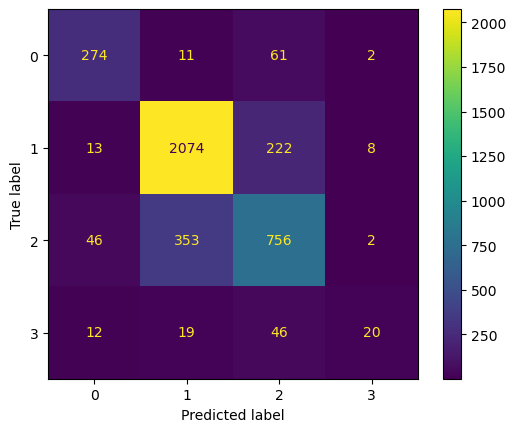

0.7906917262369099

In [28]:
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

pipe = Pipeline(steps = [('scale', 'passthrough'),
                         ('reduce_dim', PCA()),
                         ('clf', RandomForestClassifier(criterion='entropy', max_depth=75, max_features='sqrt', n_estimators=500))])

pipe_params = [
    {
        'scale': [StandardScaler()],
        'reduce_dim__n_components': ['mle', 63, 85, 125],
    },
    {
        'reduce_dim__n_components': [None]
    }
]

grid = GridSearchCV(pipe,pipe_params, cv=cross_val, scoring='f1_weighted', verbose=1, refit=True, n_jobs = -1)

grid.fit(x_train_balanced, y_train_balanced)

hist['Rf_PCA'] = grid

print(f' Best score: {grid.best_score_}')
print(f" Best parameters: {grid.best_params_}")
report(grid.best_estimator_)

# Submission

In [32]:
def submit(clf):
    submission = pd.read_csv("/kaggle/input/csm6420-a2/test_feat.csv")
    nan = submission.fillna(value=0)
    ids = nan.ID
    submission_data = nan.drop(columns='ID')
    predictions = clf.predict(submission_data)
    out = label_encoder.inverse_transform(predictions)
    submission_dict = {"ID": ids, "Predicted": out}
    final = pd.DataFrame.from_dict(submission_dict)
    final.to_csv(f"submission.csv", index=False)



==RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       n_estimators=500)==
weighted average f1 score = 0.8214


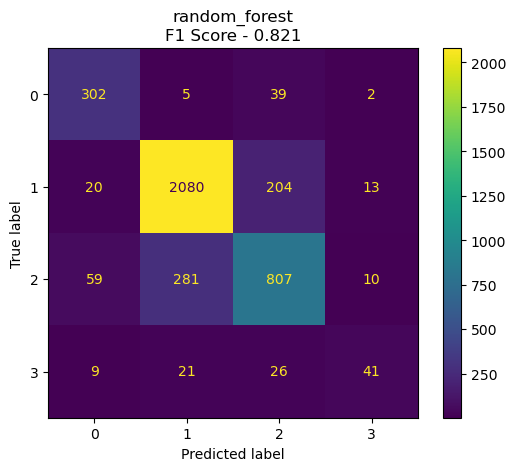



==GaussianNB(var_smoothing=2.310129700083158e-09)==
weighted average f1 score = 0.6925


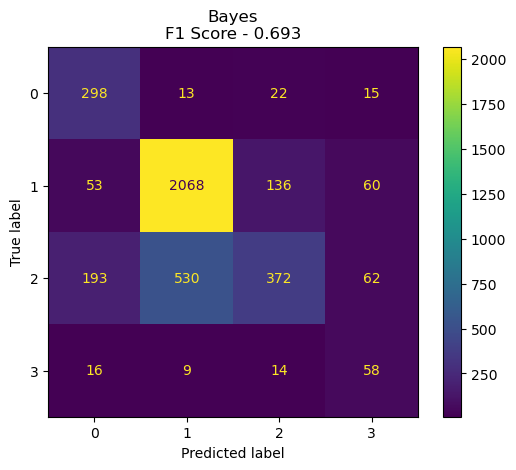



==KNeighborsClassifier(algorithm='ball_tree', n_neighbors=26, weights='distance')==
weighted average f1 score = 0.6533


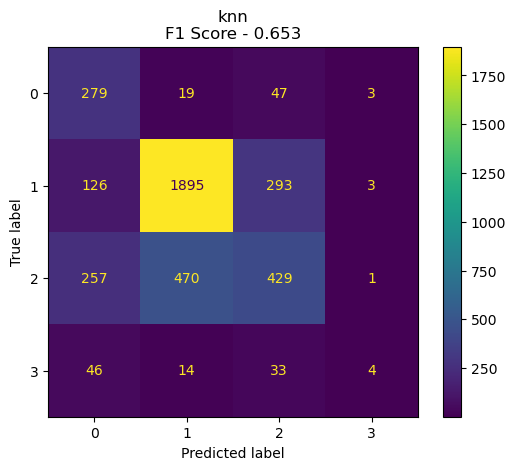



==Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dim', PCA(n_components=85)),
                ('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=75,
                                        max_features='sqrt',
                                        n_estimators=500))])==
weighted average f1 score = 0.7943


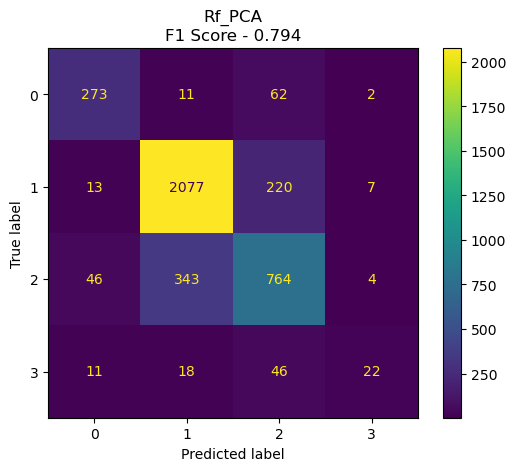

****

Best Classifier = RandomForestClassifier(criterion='entropy', max_depth=50, max_features='sqrt',
                       n_estimators=500)

Test Score = 0.82137 

Train Score = 0.91378


In [35]:
best_train_score = 0
best_test_score = 0
submission_clf = None

for clf in hist:
    test_f1 = report(hist[clf].best_estimator_, clf)
    if test_f1 > best_test_score:
        best_test_score = test_f1
        submission_clf = hist[clf].best_estimator_
        best_train_score = hist[clf].best_score_

print(f"****\n\nBest Classifier = {submission_clf}\n\nTest Score = {best_test_score:.5f} \n\nTrain Score = {best_train_score:.5f}")
submit(submission_clf)